## Basic Track Analysis - Pyspark
This guide performs similar actions as the "Basic Track Analysis" notebook, but it accomplishes it using Pyspark, which is the Python API for Spark. By using the `run_python_script` functionality present in the ArcGIS API for Python, we can leverage Spark functionality in our GeoAnalytics Server to get blazing fast analysis results. In this notebook, we'll use Pyspark to examine a couple different sets of track data to demostrate how to effectively visualize, query, and analyze the tracks.

This guide assumes that:
1. You are an administrator for your organization OR you are a Track Viewer that has privileges to create content.
2. You are using Enterprise 10.7+
3. You have GeoAnalytics Server as part of your Enterprise deployment
4. You are running this with the latest version of the ArcGIS API for Python

In [21]:
import arcgis
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView

arcgis.env.process_spatial_reference = "102100"

gis = GIS("https://tracker4.dev.geocloud.com/portal", "trackeradmin", verify_cert=False)
if not arcgis.geoanalytics.is_supported(gis):
    raise Exception("GeoAnalytics is not supported for this organization")

Enter password: ········


### First, let's get familiar with our data

We will access track data through the track view, see who is present, and visualize Tracks at the 2019 Esri Developer Summit. We are going to be using a specific track view that contains tracks for several members of the Tracker product team.

In [55]:
tracks_layer = gis.admin.location_tracking.tracks_layer
webmap = gis.map("Kansas", zoomlevel=4)
webmap.add_layer(tracks_layer)
webmap


MapView(layout=Layout(height='400px', width='100%'))

### That's a lot of tracks!
As you can see, we have a ton of tracks in the layer. That's going to make performing any of our analysis operations take quite a bit of time. Let's return all the tracks as a Data Frame and see how long it takes to do so. 

In [87]:
import datetime
start_time = datetime.datetime.now()
tracks = tracks_layer.query("activity=5 AND speed < 5")
print("Time Elapsed: " + str(datetime.datetime.now() - start_time))
print("Number of Tracks in Dataframe: " + str(len(tracks)))

Time Elapsed: 0:00:01.883318
Number of Tracks in Dataframe: 9446


### Now let's try that in PySpark
We'll use the `run_python_script` function available in the ArcGIS Python API to run a code block which filters those tracks. The code block contains the `filter()` function which can be performed on a Spark Dataframe.

In [102]:
start_time = datetime.datetime.now()
code = '''
import datetime
print(layers[0].filter((layers[0].activity == 5) & (layers[0].speed < 5)).count())
'''
arcgis.geoanalytics.manage_data.run_python_script(code=code, layers=[tracks_layer])
print("Time Elapsed: " + str(datetime.datetime.now() - start_time))

Attaching log redirect
Log level set to DEBUG
Detaching log redirect


Time Elapsed: 0:00:22.709688


### Now, let's compare performance of several geoanalytics tools using standard GeoAnalytics and using Pyspark

In this example, we will created some aggregated hexagon bins to analyze where the most frequently visted locations were. We'll perform two actions in each example. First, we will filter the track points to only include those which are walking and the user was traveling under 3 m/s. Second, we will aggregate the points using the `aggregate_points` functionality in GeoAnalytics. However, the first example will use the Python API directly, which the second example will use `run_python_script`. 

In [100]:
start_time = datetime.datetime.now()
from arcgis.geoanalytics.summarize_data import aggregate_points
aggregated_tracks = aggregate_points(point_layer=tracks_layer,
                                     bin_size=50,
                                     bin_size_unit="Meters",
                                     bin_type="Hexagon")
print("Time Elapsed: " + str(datetime.datetime.now() - start_time))

start_time = datetime.datetime.now()
code_2 = '''
aggregated_tracks = geoanalytics.aggregate_points(point_layer=layers[0],
                                     bin_size=50,
                                     bin_size_unit="Meters",
                                     bin_type="Hexagon")
aggregated_tracks.write.format('webgis').save('RunPythonScriptTest_{0}'.format(time.time()))
'''
arcgis.geoanalytics.manage_data.run_python_script(code=code_2, layers=[tracks_layer])
print("Time Elapsed: " + str(datetime.datetime.now() - start_time))

Attaching log redirect
Log level set to DEBUG
Detaching log redirect


Time Elapsed: 0:00:52.131888
<Item title:"Aggregate_Points_Analysis_EGQ0WK" type:Feature Layer Collection owner:trackeradmin>


### Looks like run_python_script is a particularly good option!
The function gets its advantage from the fact that you don't have to write out intermediate results - the entire program is executed for you on the GeoAnalytics Server, so you only have to deal with input and output. The more functions you want to chain together, the better performance improvement you'll see!

Now, let's try a second example where we chain together three actions: in this one, we will find point clusters for areas where users congregated, summarize the speed of those cluster areas, and then create separate polygons for those cluster locations with the speed data joined.


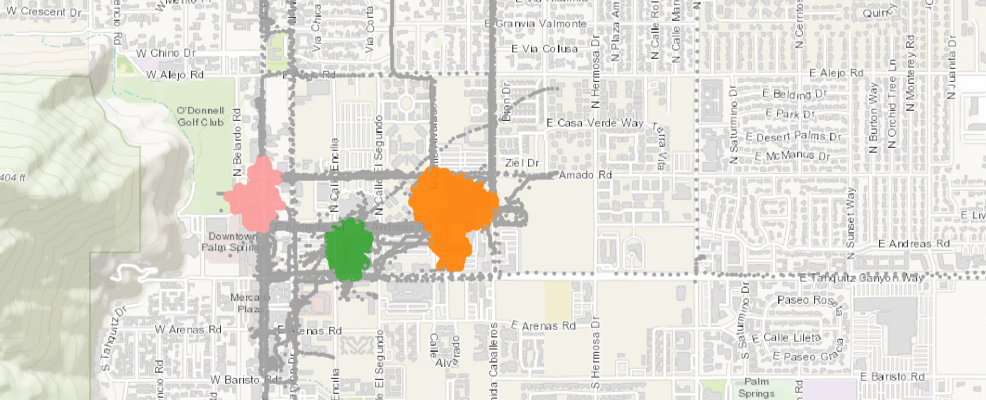

In [13]:
from arcgis.geoanalytics.analyze_patterns import find_point_clusters
clusters = find_point_clusters(
    track_view.tracks_layer,
    "DBSCAN",
    500,
    search_distance=50,
    distance_unit="Meters"
)
webmap = gis.map("Palm Springs Convention Center, CA", zoomlevel=15)
webmap.add_layer(clusters.layers[0])
webmap

#### Calculate acceleration and build lines
Since all of the track data is stored as lines, we can use the reconstruct tracks tool to generate lines to visualize the actual paths people took.


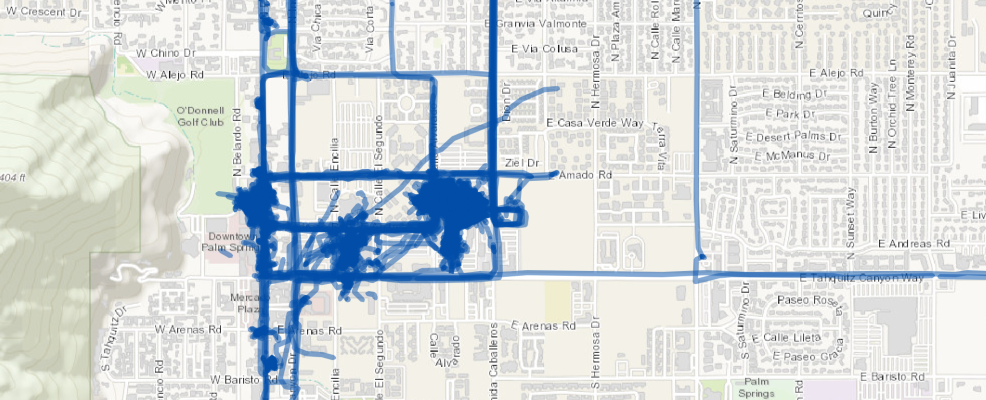

In [15]:
from arcgis.geoanalytics.summarize_data import reconstruct_tracks
track_lines = reconstruct_tracks(track_view.tracks_layer,
                                     track_fields="created_user",
                                     method="Geodesic",
                                     time_boundary_split=5,
                                     time_boundary_split_unit="Minutes",
                                     distance_split=100,
                                     distance_split_unit="Meters"
                               )
webmap = gis.map("Palm Springs Convention Center, CA", zoomlevel=15)
webmap.add_layer(track_lines.layers[0], {"renderer":{"type":"simple","symbol":{"color":[0,77,168,126],"width":3.75,"type":"esriSLS","style":"esriSLSSolid"}},"transparency":0})
webmap

### Deriving new datasets
Let's look at this same user but at in Portland, ME and analyze their driving habits


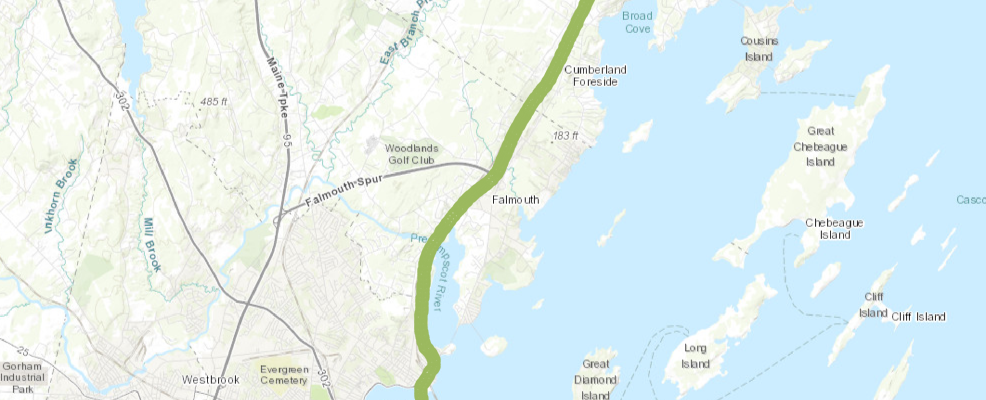

In [23]:
track_view.tracks_layer.filter = "activity = 5 AND created_user = 'apulver' AND horizontal_accuracy < 100 AND location_timestamp > date '2019-07-01' AND location_timestamp < date '2019-07-02'"
webmap = gis.map("Falmouth, ME", zoomlevel=12)
webmap.add_layer(track_view.tracks_layer)
webmap

Let's render the points based on the speed. Darker orange/red will indicate a higher speed.


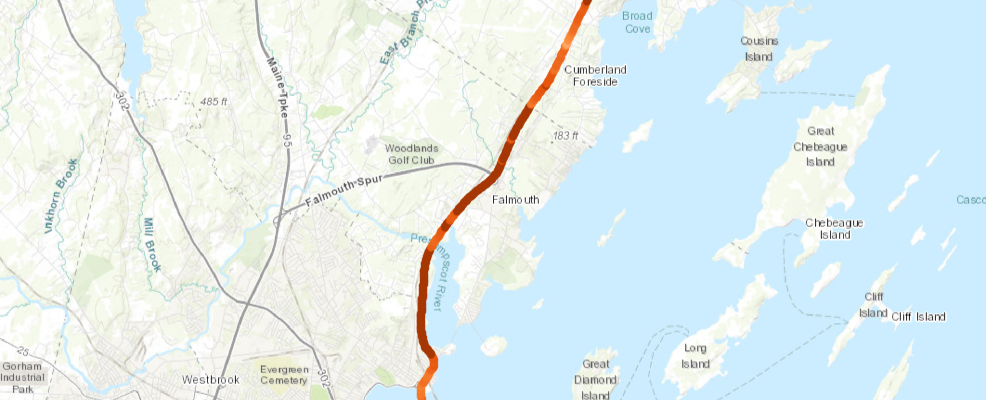

In [25]:
renderer = {"visualVariables": [
    {"type": "colorInfo",
     "field": "speed",
     "valueExpression": None,
     "stops": [
         {"value": -1, "color": [254, 237, 222, 255], "label": "N/A"},
         {"value": 9.9, "color": [253, 190, 133, 255], "label": "0-10"},
         {"value": 19.9, "color": [253, 141, 60, 255], "label": "10-20"},
         {"value": 29.9, "color": [230, 85, 13, 255], "label": "20-30"},
         {"value": 30, "color": [166, 54, 3, 255], "label": "> 30+"}
     ]
     }
],
    "type": "classBreaks",
    "field": "speed",
    "minValue": 0,
    "classBreakInfos": [
        {"symbol":
             {"color": [170, 170, 170, 255],
              "size": 6,
              "angle": 0,
              "xoffset": 0,
              "yoffset": 0,
              "type": "esriSMS",
              "style": "esriSMSCircle",
              "outline": {
                  "color": None,
                  "width": 0.375,
                  "type": "esriSLS",
                  "style": "esriSLSNull"}},
         "classMaxValue": 100}
    ]
}
webmap = gis.map("Falmouth, ME", zoomlevel=12)
webmap.add_layer(track_view.tracks_layer, {"renderer": renderer})
webmap

You can see how `apulver` speeds up and slows down in certain areas. We can leverage the GeoAnalytics calculate field tool to determine the mean acceleration between consectutive points. This will allow to to see where `apulver` is braking or accelerating.

In [26]:
from arcgis.geoanalytics.manage_data import calculate_fields

acceleration_expression = """
($track.field["speed"].history(-2)[0] - $feature.speed)/(DateDiff($track.field["location_timestamp"].history(-2)[0], $feature.location_timestamp, "seconds"))
"""

acceleration = calculate_fields(track_view.tracks_layer,
                               "acceleration",
                               "Double",
                               acceleration_expression,
                               track_aware=True,
                               track_fields="created_user",
                               )


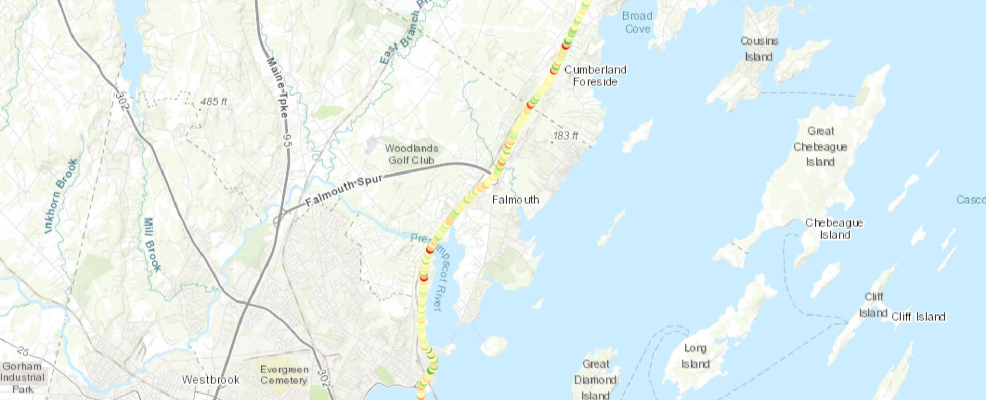

In [28]:
renderer = {"visualVariables": [
    {"type": "colorInfo",
     "field": "acceleration",
     "valueExpression": None,
     "stops": [
         {"value": -2, "color": [215, 25, 28, 255], "label": "Hard-braking"},
         {"value": -1, "color": [253, 174, 97, 255], "label": "Light-braking"},
         {"value": 0, "color": [255, 255, 191, 255], "label": "Normal"},
         {"value": 1, "color": [166, 217, 106, 255], "label": "Light-acceleration"},
         {"value": 2, "color": [26, 150, 65, 255], "label": "Hard-acceleration"}
     ]
     }
],
    "type": "classBreaks",
    "field": "acceleration",
    "minValue": -10,
    "classBreakInfos": [
        {"symbol":
             {"color": [170, 170, 170, 255],
              "size": 6,
              "angle": 0,
              "xoffset": 0,
              "yoffset": 0,
              "type": "esriSMS",
              "style": "esriSMSCircle",
              "outline": {
                  "color": None,
                  "width": 0.375,
                  "type": "esriSLS",
                  "style": "esriSLSNull"}},
         "classMaxValue": 100}
    ]
}
webmap = gis.map("Falmouth, ME", zoomlevel=12)
webmap.add_layer(acceleration.layers[0], {"renderer": renderer})                                   
webmap

You can see there are some red and green dots, let's filter the layer to only show when `apulver` was braking at more than 2 m/s^2.


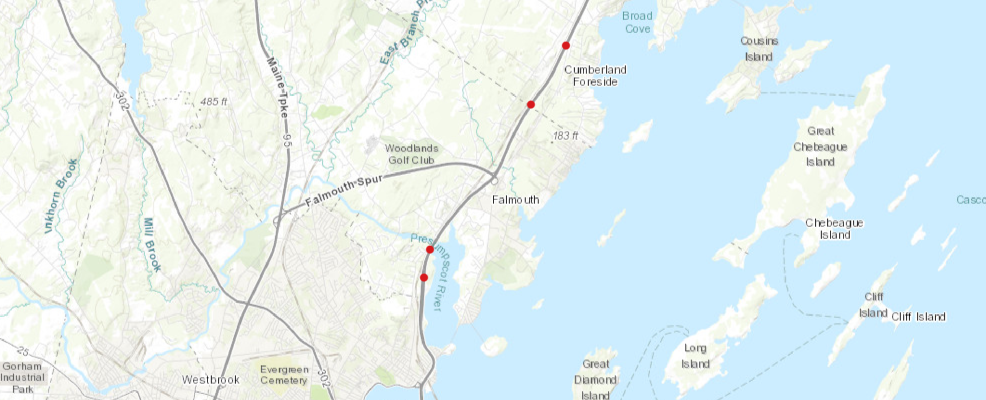

In [30]:
acceleration.layers[0].filter = "acceleration <= -2"
webmap = gis.map("Falmouth, ME", zoomlevel=12)
webmap.add_layer(acceleration.layers[0], {"renderer": renderer})                                   
webmap

### Summary
We just walked through several ways to view, interogate, and analyze track data. The track data can help you answer questions about where some was, how they got there, and how long they were there. The key takeaway is that because the track data is stored in a hosted feature service, it can be leveraged by existing tools in the ArcGIS platform.